In [1]:
import re
import nltk
import emoji
import contractions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

print(nltk.data.path)

['/Users/jonasis/nltk_data', '/opt/anaconda3/nltk_data', '/opt/anaconda3/share/nltk_data', '/opt/anaconda3/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonasis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jonasis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jonasis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jonasis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Load dataset
https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/data

In [3]:
df = pd.read_csv('data/airline_tweets.csv')

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.shape

(14640, 15)

In [6]:
df = df[['tweet_id', 'airline_sentiment', 'text']]

In [7]:
df.shape

(14640, 3)

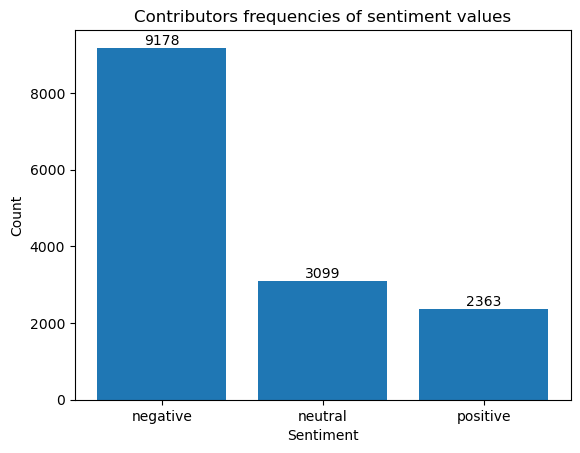

In [8]:
sentiment_counts = df['airline_sentiment'].value_counts()

bar_container = plt.bar(sentiment_counts.index, sentiment_counts.values)

plt.bar_label(bar_container)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Contributors frequencies of sentiment values')
plt.show()

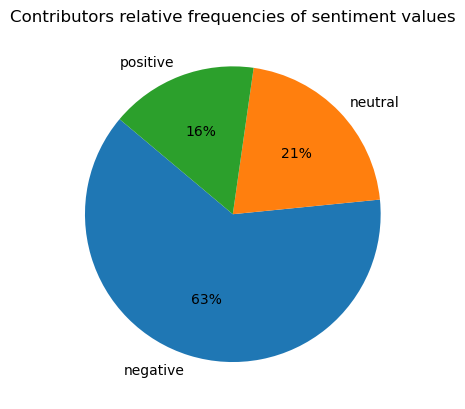

In [9]:
sentiment_counts = df['airline_sentiment'].value_counts()

sentiment_percentages = (sentiment_counts / sentiment_counts.sum()) * 100

plt.pie(sentiment_percentages, labels=sentiment_percentages.index, autopct='%1.0f%%', startangle=140)
plt.title('Contributors relative frequencies of sentiment values')
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet_id           14640 non-null  int64 
 1   airline_sentiment  14640 non-null  object
 2   text               14640 non-null  object
dtypes: int64(1), object(2)
memory usage: 343.3+ KB


## Text preprocessing

In [12]:
def normalize_text(txt):
    # Lower casing
    txt = txt.lower()

    # Removing URLs
    txt = re.sub(r'http\S+|www.\S+', '', txt)

    # Removing HTML tags
    txt = re.sub(r'<.*?>', '', txt)

    # Remove punctuation
    txt = re.sub(r'[^\w\s]', '', txt)

    # Remove numbers
    txt = re.sub(r'\d+', '', txt)

    # Remove extra spaces
    txt = ' '.join(txt.split())

    # Replacing repetitions of punctuation
    txt = re.sub(r'(\W)\1+', r'\1', txt)

    # Converting emojis to text
    txt = emoji.demojize(txt)

    # Remove special characters once again
    txt = re.sub(r"[^\w\s]", '', txt)

    # Remove contractions
    txt = contractions.fix(txt)

    txt = TextBlob(txt)
    # Tokenization and stopwords removal
    txt_tokens = [word for word in txt.words if word not in stopwords.words('english')]

    # Lemmatization
    lemmatized_tokens = [word.lemmatize() for word in txt_tokens]

    return ' '.join(lemmatized_tokens)

In [13]:
df['text_clean'] = df['text'].apply(lambda tweet: normalize_text(tweet))

In [14]:
# Train test split
train, test = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)

In [15]:
train.shape

(10248, 4)

In [16]:
test.shape

(4392, 4)

## Sentiment analysis

In [18]:
def sentiment_analysis(polarity):
    if polarity < 0:
        return 'negative'
    elif polarity == 0:
        return 'neutral'
    else:
        return 'positive'
    
def get_polarity(text):
    return TextBlob(text).sentiment.polarity
    
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [19]:
df['subjectivity'] = df['text_clean'].apply(get_subjectivity)
df['polarity'] = df['text_clean'].apply(get_polarity)
df['blob_sentiment'] = df['polarity'].apply(sentiment_analysis)

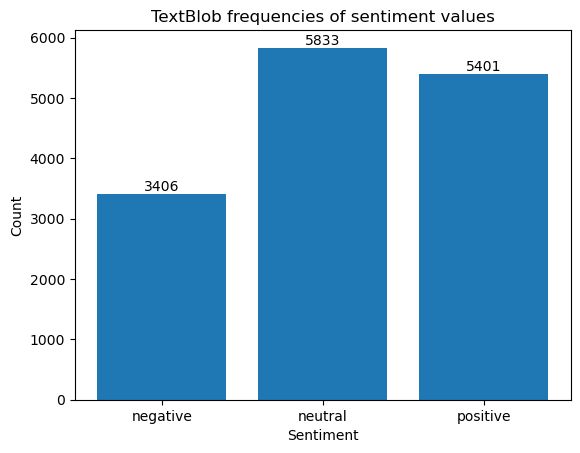

In [20]:
sentiment_order = ['negative', 'neutral', 'positive']
sentiment_counts = df['blob_sentiment'].value_counts().reindex(sentiment_order, fill_value=0)

bar_container = plt.bar(sentiment_counts.index, sentiment_counts.values)

plt.bar_label(bar_container)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('TextBlob frequencies of sentiment values')

plt.show()

In [21]:
df['polarity'].describe()

count    14640.000000
mean         0.045842
std          0.314796
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.200000
max          1.000000
Name: polarity, dtype: float64

In [22]:
cm = confusion_matrix(df['airline_sentiment'], df['blob_sentiment'], labels=['negative', 'neutral', 'positive'])

# Convert to percentage
cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100

# Calculate accuracy
accuracy = np.trace(cm) / np.sum(cm)

cm, cm_percentage, accuracy

(array([[2997, 3532, 2649],
        [ 289, 1822,  988],
        [ 120,  479, 1764]]),
 array([[32.65417302, 38.4833297 , 28.86249728],
        [ 9.3255889 , 58.79315908, 31.88125202],
        [ 5.07829031, 20.27084215, 74.65086754]]),
 0.4496584699453552)

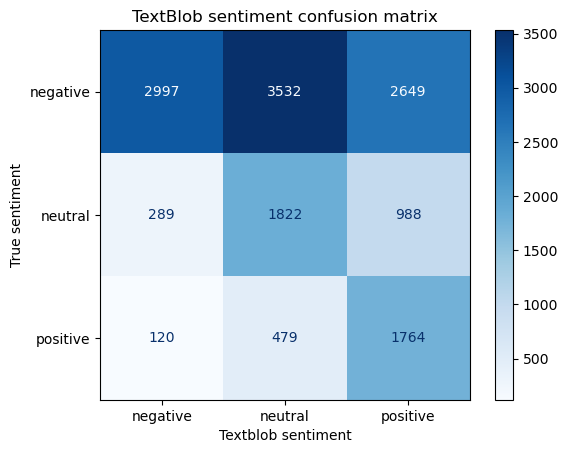

In [23]:
cm_labels = ['negative', 'neutral', 'positive']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
disp.plot(cmap='Blues', values_format="d")
plt.ylabel('True sentiment')
plt.xlabel('Textblob sentiment')
plt.title('TextBlob sentiment confusion matrix')

plt.show()

## Classifiers

In [25]:
train_data = list(train[['text_clean', 'airline_sentiment']].itertuples(index=False, name=None))
test_data = list(test[['text_clean', 'airline_sentiment']].itertuples(index=False, name=None))

### NaiveBayesClassifier

In [27]:
from textblob.classifiers import NaiveBayesClassifier

cl = NaiveBayesClassifier(train_data)

In [28]:
df['bayes_sentiment'] = df['text_clean'].apply(lambda tweet: cl.classify(tweet))

In [29]:
cl.accuracy(test_data)

0.7873406193078324

In [30]:
cl.show_informative_features()

Most Informative Features
      contains(favorite) = True           positi : negati =     31.8 : 1.0
        contains(street) = True           neutra : negati =     29.7 : 1.0
   contains(outstanding) = True           positi : negati =     26.7 : 1.0
        contains(battle) = True           neutra : negati =     25.9 : 1.0
       contains(awesome) = True           positi : neutra =     24.8 : 1.0
     contains(beautiful) = True           positi : negati =     24.1 : 1.0
      contains(flighted) = True           negati : positi =     24.1 : 1.0
       contains(amazing) = True           positi : negati =     23.9 : 1.0
         contains(kudos) = True           positi : negati =     23.4 : 1.0
     contains(excellent) = True           positi : negati =     22.3 : 1.0


In [31]:
cl.classify("Today was a good flight")

'negative'

In [32]:
good_flight = TextBlob("Today was a good flight").sentiment.polarity

sentiment_analysis(good_flight)

'positive'

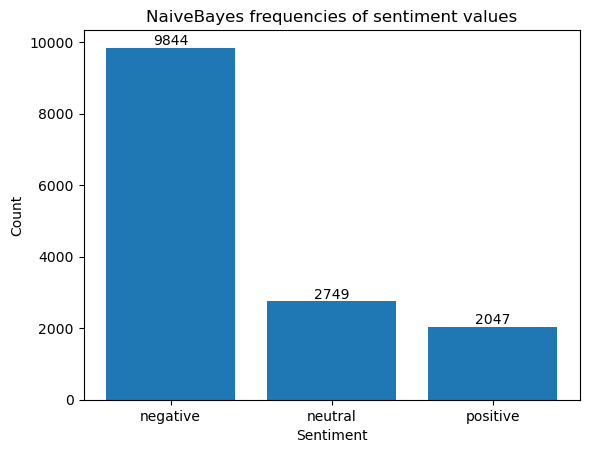

In [33]:
sentiment_order = ['negative', 'neutral', 'positive']
sentiment_counts = df['bayes_sentiment'].value_counts().reindex(sentiment_order, fill_value=0)

bar_container = plt.bar(sentiment_counts.index, sentiment_counts.values)

plt.bar_label(bar_container)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('NaiveBayes frequencies of sentiment values')

plt.show()

### MaxEntClassifier

In [35]:
from textblob.classifiers import MaxEntClassifier

maxent = MaxEntClassifier(train_data)

In [36]:
maxent.accuracy(test_data)

  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.163


/opt/anaconda3/lib/python3.11/site-packages/nltk/classify/maxent.py:1381: RuntimeWarning: overflow encountered in power
  exp_nf_delta = 2**nf_delta
/opt/anaconda3/lib/python3.11/site-packages/nltk/classify/maxent.py:1383: RuntimeWarning: invalid value encountered in multiply
  sum1 = numpy.sum(exp_nf_delta * A, axis=0)
/opt/anaconda3/lib/python3.11/site-packages/nltk/classify/maxent.py:1384: RuntimeWarning: invalid value encountered in multiply
  sum2 = numpy.sum(nf_exp_nf_delta * A, axis=0)


         Final               nan        0.216


0.20127504553734063

In [37]:
maxent.classify("Today was a good flight")

'neutral'

### DecisionTreeClassifier

In [39]:
from textblob.classifiers import DecisionTreeClassifier

dtc = DecisionTreeClassifier(train_data)

In [40]:
#dtc.accuracy(test_data)

In [41]:
#dtc.classify("Today was a good flight")

## Smaller sample

In [43]:
small_amout = 100

num_negative = int(0.63 * small_amout)
num_neutral = int(0.21 * small_amout)
num_positive = int(0.16 * small_amout)

# Sample the rows for each sentiment category
df_negative = df[df['airline_sentiment'] == 'negative'].sample(n=num_negative, random_state=1)
df_neutral = df[df['airline_sentiment'] == 'neutral'].sample(n=num_neutral, random_state=1)
df_positive = df[df['airline_sentiment'] == 'positive'].sample(n=num_positive, random_state=1)

# Combine the samples into a new DataFrame
small_df = pd.concat([df_negative, df_neutral, df_positive])

# Shuffle the rows in the new DataFrame
small_df = small_df.sample(frac=1, random_state=42).reset_index(drop=True)

small_train, small_test = train_test_split(small_df, test_size=0.3, random_state=42, shuffle=True)

small_train_data = list(small_train[['text_clean', 'airline_sentiment']].itertuples(index=False, name=None))
small_test_data = list(small_test[['text_clean', 'airline_sentiment']].itertuples(index=False, name=None))

### NaiveBayesClassifier

In [45]:
from textblob.classifiers import NaiveBayesClassifier

small_cl = NaiveBayesClassifier(small_train_data)

In [46]:
small_cl.accuracy(small_test_data)

0.7

### MaxEntClassifier

In [48]:
from textblob.classifiers import MaxEntClassifier

small_maxent = MaxEntClassifier(small_train_data)

In [49]:
small_maxent.accuracy(small_test_data)

  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.200
             2          -0.30958        0.986
             3          -0.11735        0.986
             4          -0.06079        0.986
             5          -0.03762        0.986
             6          -0.02578        0.986
             7          -0.01909        0.986
             8          -0.01514        0.986
             9          -0.01276        0.986
            10          -0.01132        0.986
            11          -0.01043        0.986
            12          -0.00988        0.986
            13          -0.00954        0.986
            14          -0.00932        0.986
            15          -0.00919        0.986
            16          -0.00910        0.986
            17          -0.00904        0.986
            18          -0.00900        0.986
            19          -0.00897        0.986
 

0.6666666666666666

### DecisionTreeClassifier

In [51]:
from textblob.classifiers import DecisionTreeClassifier

small_dtc = DecisionTreeClassifier(small_train_data)

In [52]:
small_dtc.accuracy(small_test_data)

0.5

In [53]:
df['text_clean'].str.contains("not",regex=False).sum()

655